In [138]:
%pip install -qU python-dotenv
from dotenv import load_dotenv
from pathlib import Path
import os

env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)
openai_api_key = os.environ.get("OPENAI_API_KEY")

# Define snowflake connection parameters
user="YUEMIAO"
password="Ym2511984"
account="pqjivrj-svb99131"
warehouse="COMPUTE_WH"
role="ACCOUNTADMIN"
database="GITHUB_ARCHIVE"
schema="CYBERSYN"

from langchain_community.document_loaders import SnowflakeLoader

def databaseloader(query:str):
    loader = SnowflakeLoader(
        query=query,
        user=user,
        password=password,
        account=account,
        warehouse=warehouse,
        role=role,
        database=database,
        schema=schema)
    return loader.load()


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -qU langchain-experimental
%pip install -qU "snowflake-snowpark-python[pandas]" snowflake-snowpark-python snowflake-sqlalchemy
%pip install -qU langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

import re   
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_react_agent
from langchain.agents.agent_types import AgentType
from langchain_community.agent_toolkits import SQLDatabaseToolkit, create_sql_agent
from langchain.sql_database import SQLDatabase
from snowflake.snowpark import Session
from langchain_core.tools import tool
from langchain_core.prompts.prompt import PromptTemplate
from typing import List
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



In [139]:
tables = databaseloader("show objects")

for item in tables:
    print (item) # cannot figure out code to extract individual attributes
    print ("-"*10)

page_content='created_on: 2024-05-17 14:05:05.677000-07:00
name: CYBERSYN_DATA_CATALOG
database_name: GITHUB_ARCHIVE
schema_name: CYBERSYN
kind: VIEW
comment: A catalog of all Cybersyn tables. Metadata about the tables includes descriptions, data sources, related tables, and more.
cluster_by: 
rows: 0
bytes: 0
owner: 
retention_time: 1
owner_role_type: 
budget: None
is_dynamic: N'
----------
page_content='created_on: 2024-02-15 20:48:59.592000-08:00
name: GITHUB_EVENTS
database_name: GITHUB_ARCHIVE
schema_name: CYBERSYN
kind: VIEW
comment: Event details (e.g., push, fork, issues, pull requests) for public Github repositories.

The GitHub Archive is a historical record of public activities on GitHub. This archive includes data on various events such as push operations, forks, issues opened, and pull requests across all the public repositories on GitHub in a single schema. This data is useful for recruiting, investing, lead-gen, due diligence, customer support among others.

Provides his

In [442]:
# Get all tables info

def get_table_info(database:str,schema:str,context:list):
    class Table(BaseModel):
        tablename_list: List[str]=Field(description="list of all table names in the database. Make sure to format the fullnames following this formula: {database}.{schema}.name ")
        tabledescription_list: List[str]=Field(description="list of all table descriptions. Make sure to include the table name infront of its description")

    llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini')
    system_msg_tables = """
    You are a snowflake SQL expert.
    You are given a {database}{schema} with list of table details in {context}.
    Your goal is to extract specific table information to help user perform subsequent SQL functions.
    """
    prompt = ChatPromptTemplate.from_messages(
        [("system", system_msg_tables.format(database=database,schema=schema,context=tables)),
         ("human", "{input}") ])
    table_chain = prompt|llm.with_structured_output(Table)
    table_info = table_chain.invoke({"input": ""} )
    return table_info

table_info=get_table_info(database,schema,tables)
table_info.tabledescription_list


['CYBERSYN_DATA_CATALOG: A catalog of all Cybersyn tables. Metadata about the tables includes descriptions, data sources, related tables, and more.',
 'GITHUB_EVENTS: Event details (e.g., push, fork, issues, pull requests) for public Github repositories. The GitHub Archive is a historical record of public activities on GitHub. This archive includes data on various events such as push operations, forks, issues opened, and pull requests across all the public repositories on GitHub in a single schema. This data is useful for recruiting, investing, lead-gen, due diligence, customer support among others. Provides historical records for each action on GitHub by ID. Each row represents a unique GitHub action in a public repository (REPOSITORY_ID), with detailed data on the associated actor, repository, and organization and detailed data on the payload for that action. Payloads vary based on the event type.',
 'GITHUB_REPOS: Aggregate Github repo data, providing the first and last seen dates o

In [454]:
# Get SQL code to query column info

def get_column_and_row_sql(database:str,schema:str,table_info):
    class ColumnSQL(BaseModel):
        sqlcode_list: List[str]=Field(description="list of SQL codes to extract the column names, their corresponding data type for each table")
        rowcount_list: List[str]=Field(description="list of SQL codes to extract table name and the number of rows for each table")

    llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini')
    system_msg_columns = """
    You are a snowflake SQL expert.
    You are given a {database}{schema} with list of tables listed in {table_info}.
    Your goal is to write SQL functions that can extract column names with their associated data type, and table name with their associated number of rows for each table.
    Use the following format for your SQL functions:
    '''
    SELECT ... 
    FROM ... 
    WHERE TABLE_NAME = ... 
      AND TABLE_SCHEMA = ... 
      AND TABLE_CATALOG = ...
    '''
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_msg_columns.format(database=database,schema=schema,table_info=table_info)),
        ("human", "{input}") ])
    column_chain = prompt|llm.with_structured_output(ColumnSQL)
    columnsql_code = column_chain.invoke({"input": ""} )
    return columnsql_code

column_and_row_sql=get_column_and_row_sql(database,schema,table_info)
print(column_and_row_sql.sqlcode_list)
print(column_and_row_sql.rowcount_list)



["SELECT COLUMN_NAME, DATA_TYPE FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'CYBERSYN_DATA_CATALOG' AND TABLE_SCHEMA = 'CYBERSYN' AND TABLE_CATALOG = 'GITHUB_ARCHIVE'", "SELECT COLUMN_NAME, DATA_TYPE FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'GITHUB_EVENTS' AND TABLE_SCHEMA = 'CYBERSYN' AND TABLE_CATALOG = 'GITHUB_ARCHIVE'", "SELECT COLUMN_NAME, DATA_TYPE FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'GITHUB_REPOS' AND TABLE_SCHEMA = 'CYBERSYN' AND TABLE_CATALOG = 'GITHUB_ARCHIVE'", "SELECT COLUMN_NAME, DATA_TYPE FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'GITHUB_STARS' AND TABLE_SCHEMA = 'CYBERSYN' AND TABLE_CATALOG = 'GITHUB_ARCHIVE'"]
['SELECT COUNT(*) AS ROW_COUNT FROM GITHUB_ARCHIVE.CYBERSYN.CYBERSYN_DATA_CATALOG', 'SELECT COUNT(*) AS ROW_COUNT FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_EVENTS', 'SELECT COUNT(*) AS ROW_COUNT FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_REPOS', 'SELECT COUNT(*) AS ROW_COUNT FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS']


In [456]:
# Get all column info

def get_column_info(columnsql_list:list):
    column_by_table=[]

    for sql in columnsql_list:
        match=re.search(r"TABLE_NAME\s*=\s*'([^']*)'",sql)
        if match:
            table_name=match.group(1)
            column_by_table.append(f"# ColumnNames and DataType in the {table_name} table:")
        else:
            print("table name not found")            
        columns_info=databaseloader(sql)
        
        for column in columns_info:
            column_name_match=re.search(r"COLUMN_NAME:\s*([^\n]+)",column.page_content)
            if column_name_match:
                column_name=column_name_match.group(1)
                data_type_match=re.search(r"DATA_TYPE:\s*([^\n]+)",column.page_content)
                if data_type_match:
                    data_type=data_type_match.group(1)
                    data_type=data_type.lower()
                    column_by_table.append(f"{column_name}, {data_type}")
            else:
                print("column info not found")
        column_by_table.append("")        
    return column_by_table

def format_by_line(result_list:list):
    formatted_result = "\n".join(str(result) for result in result_list)
    return formatted_result

raw_column_info_by_table = get_column_info(column_and_row_sql.sqlcode_list)
column_info_by_table=format_by_line(raw_column_info_by_table)
print(column_info_by_table)


# ColumnNames and DataType in the CYBERSYN_DATA_CATALOG table:
DATA_SOURCE_URL, array
LAST_UPDATED_TIMESTAMP, timestamp_tz
CREATED_DATE, date
LISTING_URL, array
DESCRIPTION, text
TABLE_TYPE, text
SELECT_RELATED_TABLES, array
LICENSE_URL, array
TABLE_NAME_PROPER, text
SHORT_DESCRIPTION, text
TABLE_NAME, text
DATA_SOURCE, array
LISTING_NAME, array
ENTITIES, array
DOCUMENTATION_URL, text

# ColumnNames and DataType in the GITHUB_EVENTS table:
PAYLOAD_REF, text
ISSUE_AUTHOR_ASSOCIATION, text
ORG_LOGIN, text
ACTOR_AVATAR_URL, text
PAYLOAD, variant
ISSUE_REPOSITORY_URL, text
ACTOR_DISPLAY_LOGIN, text
PAYLOAD_HEAD, text
ACTOR_GRAVATAR_ID, text
ISSUE_BODY, text
PAYLOAD_REF_TYPE, text
REPO_ID, number
LOAD_DATE, text
ISSUE_USER_ID, number
PAYLOAD_DESCRIPTION, text
PAYLOAD_USER_ID, number
ISSUE, variant
CREATED_AT, text
PAYLOAD_ACTION, text
CREATED_AT_TIMESTAMP, timestamp_tz
ISSUE_PERFORMED_VIA_GITHUB_APP, text
ISSUE_USER_LOGIN, text
ISSUE_ASSIGNEES, variant
PAYLOAD_ISSUE, variant
PAYLOAD_COMMENT

In [457]:
# get row counts by table

def get_row_count(rowsql_list:list,table_info):
    rows_by_table=[]
    for sql in rowsql_list:
        row_counts = databaseloader(sql)
        for count in row_counts:
            count_match=re.search(r"ROW_COUNT:\s*([^\n]+)",count.page_content)
            if count_match:
                row_count=count_match.group(1)
                rows_by_table.append(row_count)
            else:
                print("row count not found")
    row_count=[f"{x} has {y} rows" for x, y in zip(table_info,rows_by_table)]
    return row_count

rowcount_by_table = get_row_count(rowsql_list=column_and_row_sql.rowcount_list,table_info=table_info.tablename_list)
rowcount_by_table


['GITHUB_ARCHIVE.CYBERSYN.CYBERSYN_DATA_CATALOG has 327 rows',
 'GITHUB_ARCHIVE.CYBERSYN.GITHUB_EVENTS has 8088645708 rows',
 'GITHUB_ARCHIVE.CYBERSYN.GITHUB_REPOS has 433710209 rows',
 'GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS has 226617316 rows']

In [208]:
database_details_template = """
<tableName>
{tablename}
</tableName>

<tableDescription>
{tabledescription}
</tableDescription>

<tableSize>
{row_count}
</tableSize>

<columns>
{columns}
</columns>
"""
database_details=database_details_template.format(
    tablename=format_by_line(table_info.tablename_list),
    tabledescription=format_by_line(table_info.tabledescription_list),
    row_count=format_by_line(row_count),
    columns=column_info_by_table)


# test with this question
question = "find the repo with the top 10 repos with the highest number of accumulated star from GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS table."

In [106]:
# Define snowflake sql query tool

def stripped_text(text:str):
    return text.replace('"', '')

@tool
def db_query_tool_v3(query:str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    loader = SnowflakeLoader(
        query=stripped_text(query),
        user=user,
        password=password,
        account=account,
        warehouse=warehouse,
        role=role,
        database=database,
        schema=schema)
    return loader.load()

print(db_query_tool_v3.invoke("SELECT COUNT(*) AS total_rows FROM GITHUB_ARCHIVE.CYBERSYN.CYBERSYN_DATA_CATALOG;"))

[Document(page_content='TOTAL_ROWS: 325')]


In [465]:
chat_history=[("user", "give me the top 10 repos with the highest total number of stars"),
              ("ai", "An error occurred: 000904 (42000): SQL compilation error: error line 1 at position 20 invalid identifier 'R.REPO_URL'"),
              ("user", "Github_Repo table doesn't have a repo url column. Do not make this mistake and try again.")
              ]
context_prompt = """
You are a SQL expert. \
Your goal is to write a sequence of SQL codes to answer the user's question. \
Find the most efficient way (shortest query time) to query the database to get the final answer. \
You have the ability to store intermediate step results in a multi-step solution. \
Use a multi-step approach if you need to join more than 2 tables. Joining more than 2 tables in a single step can result in timeout. \
Also take each table's size into consideration when devising the steps (use the row count as an approxi). You want to avoid joining huge tables. \
If you have to join huge tables together, find a way to reduce the number of rows before the join. \
Here are the table details: {database_details} """

prompt =(PromptTemplate.from_template(context_prompt.format(database_details=database_details))
        + "\n DO NOT quote your SQL code in ```<code snippet>```, i.e. begin directly with select and end directly with ';' "
        + prompt_edited.partial(chat_history=chat_history))


llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
tools=[db_query_tool_v3]
agent = create_react_agent(llm, tools, prompt)
agent_executor=AgentExecutor(agent=agent,tools=tools,verbose=True,handle_parsing_errors=True,return_intermediate_steps=True)


In [416]:
prompt =(PromptTemplate.from_template(context_prompt.format(database_details=database_details))
        + "\n DO NOT quote your SQL code in ```<code snippet>```, i.e. begin directly with select and end directly with ';'\
        if SQL engine (snowflake) is giving you an error, include that directly in your error message string."
        + prompt_edited)


agent = create_react_agent(llm, tools, prompt.partial(chat_history=chat_history))
agent_executor=AgentExecutor(agent=agent,
                             tools=tools,
                             verbose=True,
                             return_intermediate_steps=True,
                             handle_parsing_errors=True,
                             max_iterations=5
                            )


In [337]:
# React Agent

# prompt
react_prompt = hub.pull("hwchase17/react")# standard react agent prompt
#prompt = react_prompt+PromptTemplate.from_template("\nPay attention to these error messages while running SQL codes previously. Do not make the same mistake this time:\n{errors}")

context_prompt = """
You are a SQL expert. \
Your goal is to write a sequence of SQL codes to answer the user's question. \
Find the most efficient way (shortest query time) to query the database to get the final answer. \
You have the ability to store intermediate step results in a multi-step solution. \
Use a multi-step approach if you need to join more than 2 tables. Joining more than 2 tables in a single step can result in timeout. \
Also take each table's size into consideration when devising the steps (use the row count as an approxi). You want to avoid joining huge tables. \
If you have to join huge tables together, find a way to reduce the number of rows before the join. \
Here are the table details: {database_details} """

def prompt_gen(context_prompt:str,database_details:str):
    
    full_prompt =(
        PromptTemplate.from_template(context_prompt.format(database_details=database_details))
        + "\n DO NOT quote your SQL code in ```<code snippet>```, i.e. begin directly with select and end directly with ';' "
        + react_prompt)
    return full_prompt

full_prompt = prompt_gen(context_prompt=context_prompt,database_details=database_details)

#llm & tools
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
tools=[db_query_tool_v3]



In [466]:
question="give me the top 10 repos with the highest total number of stars"

import traceback
from langchain_core.agents import AgentActionMessageLog



def get_result(question:str): 
    try:
        result=agent_executor.invoke({"input":question})
    except Exception as e:
        pass
    return result

failure_result=""
failure_result=get_result(question)
    



> Entering new AgentExecutor chain...
Thought: To find the top 10 repositories with the highest total number of stars, I need to aggregate the star counts from the GITHUB_STARS table and then join it with the GITHUB_REPOS table to get the repository names. Since the GITHUB_STARS table is large, I will first aggregate the star counts by REPO_ID before joining it with the GITHUB_REPOS table.

Action: db_query_tool_v3
Action Input: 
"""
SELECT REPO_ID, SUM(COUNT) AS TOTAL_STARS
FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS
GROUP BY REPO_ID
ORDER BY TOTAL_STARS DESC
LIMIT 10;
"""
[Document(page_content='REPO_ID: 28457823\nTOTAL_STARS: 480491'), Document(page_content='REPO_ID: 177736533\nTOTAL_STARS: 384876'), Document(page_content='REPO_ID: 21737465\nTOTAL_STARS: 351820'), Document(page_content='REPO_ID: 60493101\nTOTAL_STARS: 333340'), Document(page_content='REPO_ID: 13491895\nTOTAL_STARS: 330397'), Document(page_content='REPO_ID: 54346799\nTOTAL_STARS: 327658'), Document(page_content='REPO

In [468]:
#<class 'IndexError'>,list index out of range
failure_result["output"]

'The top 10 repositories with the highest total number of stars are:\n\n1. freeCodeCamp/ - 480491 stars\n2. jwasham/coding-interview-university - 333340 stars\n3. facebook/ - 260494 stars\n4. codecrafters-io/build-your-own-x - 303781 stars\n5. danistefanovic/ - 303781 stars\n6. public-apis/public-apis - 327658 stars\n7. 996icu/996.ICU - 384876 stars\n8. sindresorhus/awesome - 351820 stars\n9. kamranahmedse/developer-roadmap - 311444 stars\n10. donnemartin/system-design-primer - 281316 stars\n\n(Note: Some repository names may appear multiple times due to different forks or variations. The list above includes unique repository names with their corresponding star counts.)'

In [389]:
result

{'input': 'give me the top 10 repos with the highest total number of star with their name. Try not to include duplicates',
 'output': 'Agent stopped due to iteration limit or time limit.',
 'intermediate_steps': [(AgentAction(tool='db_query_tool_v3', tool_input='SELECT REPO_ID, SUM(COUNT) AS TOTAL_STARS\nFROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS\nGROUP BY REPO_ID\nORDER BY TOTAL_STARS DESC\nLIMIT 10;\n', log='Question: give me the top 10 repos with the highest total number of stars with their name. Try not to include duplicates.\n\nThought: To find the top 10 repositories with the highest total number of stars, I will first aggregate the star counts from the GITHUB_STARS table by REPO_ID. Then, I will join this result with the GITHUB_REPOS table to get the corresponding repository names. Since the GITHUB_STARS table is large, I will first aggregate the star counts to reduce the number of rows before joining.\n\nAction: db_query_tool_v3\nAction Input: \nSELECT REPO_ID, SUM(COUNT) AS TOT

In [ ]:
# Given a {database} {schema} {question} provided by the user, graph will:
    # 1. acquire all background database details (use databaseloader tool to show objects, get table info (name, size, description), column info)
    # 2. write and execute sql queries (use react agent with agent scratchpad)
    # 3. if successful then output result; if not redo step 2 up to 3 times with prev error messages in state

In [769]:
from typing import Annotated, Sequence, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, filter_messages
import operator
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

# snowflake connection parameters
user="YUEMIAO"
password="Ym2511984"
account="pqjivrj-svb99131"
warehouse="COMPUTE_WH"
role="ACCOUNTADMIN"
database="GITHUB_ARCHIVE"
schema="CYBERSYN"

# tools
def stripped_text(text:str):
    return text.replace('"', '')

@tool
def db_query_tool_v3(query:str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    loader = SnowflakeLoader(
        query=stripped_text(query),
        user=user,
        password=password,
        account=account,
        warehouse=warehouse,
        role=role,
        database=database,
        schema=schema)
    return loader.load()

tools=[db_query_tool_v3]

# state & memory
class State(TypedDict):
    
    database_details: str
    messages: Annotated[list[BaseMessage],add_messages]
    output_and_intermediate_steps: Annotated[list,add_messages]
    question: str

memory = MemorySaver()

# agents
def database_details_agent(state:State):
    """ prepare all the database details """
    print("------------ Getting database details ------------")
    tables=databaseloader("show objects")
    print("----- Database objects discovered -----")
    table_info=get_table_info(database=database,schema=schema,context=tables)
    print("----- Table info acquired -----")
    column_and_row_sql=get_column_and_row_sql(database=database,schema=schema,table_info=table_info)
    column_info=get_column_info(column_and_row_sql.sqlcode_list)
    print("----- Column info acquired -----")
    rowcount_info=get_row_count(rowsql_list=column_and_row_sql.rowcount_list,table_info=table_info.tablename_list)
    print("----- Row count by table acquired -----")
    database_details=database_details_template.format(
        tablename=format_by_line(table_info.tablename_list),
        tabledescription=format_by_line(table_info.tabledescription_list),
        row_count=format_by_line(rowcount_info),
        columns=format_by_line(column_info) )
    print("----- Database details complete -----")
    return{"database_details":database_details,
           "messages": [AIMessage(content="successfully acquired table (name, description, size) and column information. Preparing to query database...")]
          }

def sql_gen_run_agent(state:State):
    """ generate and run SQL to answer user's question """
    print("---------- Querying snowflake database ----------")
    messages = state["messages"]
    database_details=state["database_details"]
    prompt =(PromptTemplate.from_template(context_prompt.format(database_details=database_details))
        + "\n DO NOT quote your SQL code in ```<code snippet>```, i.e. begin directly with select and end directly with ';' "
        + prompt_edited.partial(chat_history=messages))
    agent = create_react_agent(llm, tools, prompt)
    executor=AgentExecutor(agent=agent,tools=tools,verbose=True,return_intermediate_steps=True,handle_parsing_errors=True)
    try:
        result = executor.invoke({"input": state["question"]})
    except Exception as e:
        print("----- Query failed -----")
        error_message=f"Query failed: {e}"
        return {"messages": [AIMessage(content=error_message)]}
    # if no error, go ahead reply user
    return {"messages": [AIMessage(content=result["output"])],
            "output_and_intermediate_steps": [AIMessage(content="Output:{}\nIntermediate_steps:{}".format(result["output"],result["intermediate_steps"]))],
            "question": messages[0]
           }

# human input node
def ask_human(human_input,state:State):
    """ ask human for input """
    return {"messages":[HumanMessage(content=human_input)]}


# loop logic
class next_step(BaseModel):
    """ route model to the appropriate next action: back to query, web search, edit raw SQL output, reflect on mistakes or end"""
    rephrased_question:str=Field(description="rephrased question which best represents what user is looking for")
    next_step:Literal["back_to_query","web_search","editor_llm","reflection_llm","end"]=Field(description="what model should do next? chose from set of actions: back to query, web search, edit previous SQL result, reflect on mistakes, end")

llm = ChatOpenAI(temperature=0,model="gpt-4o-mini")
nextstep_system_msg="""
Given user's feedback to AI assistant's answer and the conversation history, you are responsible for: \
First rephrase user's feedback to a fuller question given user's original question and new feedback input. \ 
Then route it to one of the following options: re-query sql database, conduct web research, edit the raw SQL ouput from previous steps, reflection on mistakes, or end the process.
"""
nextstep_prompt=ChatPromptTemplate.from_messages([
    ("system",nextstep_system_msg),
    ("placeholder", "{messages}") ])

next_step_chain=nextstep_prompt|llm.with_structured_output(next_step)

def next_action(state:State):
    """ base on user feedback, should agent re-query the database, search the web, edit previous SQL results, reflect on mistakes or simply end"""
    messages=state["messages"]
    human_messages=filter_messages(messages,include_types="human")
    next_action=next_step_chain.invoke({"messages":human_messages})
    return {"messages":[AIMessage(content=next_action.next_step)],
            "question": next_action.rephrased_question
           }
    
def action_router(state:State):
    messages=state["messages"]
    last_message=messages[-1]
    if last_message.content == "back_to_query":
        return "back_to_query"
    elif last_message.content == "web_search":
        return "web_search"
    elif last_message.content == "editor_llm":
        return "editor_llm"
    elif last_message.content == "reflection_llm":
        return "reflection_llm"
    else:
        return "end"

tavily_api_key = os.environ.get("TAVILY_API_KEY")
web_search_tool = TavilySearchResults(max_results=3,
                                      include_answer=True,
                                      include_raw_content=False,)

def web_search(state:State):
    print("---------- Searching the internet ----------")
    combined_list=[]
    question = state["question"]
    docs=web_search_tool.invoke({"query":question})
    for d in docs:
        combined_text=f"{d['content']} ({d['url']})"
        combined_list.append(combined_text)
    web_results = "\n".join(combined_list)
    return {"messages":[AIMessage(content=web_results)]}


def editor_llm(state:State):
    print("---------- Editing results ----------")
    sql_output=state["output_and_intermediate_steps"][-1].content
    print(f"previous sql output & intermediate steps: {sql_output}")
    user_request=state["messages"][-2].content #last human input
    print(f"user request: {user_request}")
    system_msg="""You are a helpful assistant. Base on user's requirements, edit the SQL query output {sql_output} accordingly"""
    prompt=ChatPromptTemplate.from_messages([
        ("system",system_msg.format(sql_output=sql_output)),
        ("placeholder","{messages}") ])
    editor_chain=prompt|llm
    editor_result=editor_chain.invoke({"messages":[("user",user_request)]})
    return {"messages":[AIMessage(content=editor_result.content)]}


def reflection_llm(state:State):
    print("---------- Reflecting on my errors ----------")
    sql_errors=state["messages"][-2].content #last human input summarizing what ai did & went wrong
    print(f"previous errors: {sql_errors}")
    system_msg="""You are a snowflake SQL expert. Reflect on your previous mistake so that you'll not make similar mistakes again in the future"""
    prompt=ChatPromptTemplate.from_messages([
        ("system",system_msg),
        ("placeholder","{messages}") ])
    reflection_chain=prompt|llm
    reflection_result=reflection_chain.invoke({"messages":[("user",sql_errors)]})
    return {"messages":[AIMessage(content=reflection_result.content)]}
    


# define graph
snowflake_graph = StateGraph(State)

snowflake_graph.add_node("prep_step",database_details_agent)
snowflake_graph.add_node("sql_execution",sql_gen_run_agent)
snowflake_graph.add_node("human_input",ask_human)
snowflake_graph.add_node("next_action",next_action)
#tavily_tool_node = ToolNode(tools=[web_search_tool])
snowflake_graph.add_node("web_search",web_search)
snowflake_graph.add_node("editor_llm",editor_llm)
snowflake_graph.add_node("reflection_llm",reflection_llm)

snowflake_graph.add_edge(START,"prep_step")
snowflake_graph.add_edge("prep_step","sql_execution")
snowflake_graph.add_edge("sql_execution","human_input")
snowflake_graph.add_edge("human_input","next_action")
snowflake_graph.add_conditional_edges(
    "next_action",
    action_router,
    {"back_to_query":"sql_execution",
     "web_search":"web_search",
     "editor_llm":"editor_llm",
     "reflection_llm":"reflection_llm",
     "end":END} )
snowflake_graph.add_edge("web_search","human_input")
snowflake_graph.add_edge("editor_llm","human_input")
snowflake_graph.add_edge("reflection_llm","human_input")
graph=snowflake_graph.compile(checkpointer=memory,interrupt_before=["human_input"])

# tool message for reflection?
    

In [790]:
config = {"configurable": {"thread_id": "4"}}

events=graph.stream(
    {"messages":[("user","find me the top 50 repos by total stars in the last month")]},
    config,
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

find me the top 50 repos by total stars in the last month
------------ Getting database details ------------
----- Database objects discovered -----
----- Table info acquired -----
----- Column info acquired -----
----- Row count by table acquired -----
----- Database details complete -----
================================== Ai Message ==================================

successfully acquired table (name, description, size) and column information. Preparing to query database...
---------- Querying snowflake database ----------


> Entering new AgentExecutor chain...
Question: find me the top 50 repos by total stars in the last month
Thought: To find the top 50 repositories by total stars in the last month, I will first filter the GITHUB_STARS table for the last month, then aggregate the star counts by REPO_ID, and finally join with the GITHUB_REPOS table to get the repository names. This will help in avoi

In [792]:
# human input - more query needed, start with "query xxx in the database"
graph.update_state(config, {"messages": "edit the list to filter off potential duplicates"}, as_node="human_input")
print(graph.get_state(config).values["question"])

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


content='find me the top 50 repos by total stars in the last month' id='60865e6f-edd1-4951-af1d-6a3769353308'
================================== Ai Message ==================================

editor_llm
---------- Editing results ----------
previous sql output & intermediate steps: Output:The top 50 repositories by total stars in the last month are as follows:

1. hacksider/Deep-Live-Cam - 29,440 stars
2. shardeum/shardeum - 15,961 stars
3. black-forest-labs/flux - 11,655 stars
4. ValdikSS/GoodbyeDPI - 10,923 stars
5. facebookresearch/segment-anything-2 - 9,572 stars
6. zen-browser/desktop - 8,645 stars
7. zen-browser/core - 8,645 stars
8. zen-browser/code - 8,645 stars
9. sindresorhus/awesome - 7,982 stars
10. Magic-PDF-Development-Team/Magic-PDF - 7,718 stars
11. magicpdf/Magic-PDF - 7,718 stars
12. myhloli/Magic-PDF - 7,718 stars
13. opendatalab/MinerU - 7,718 stars
14. practical-tutorials/project-based-learning - 7,400 stars
15. tuvtran/project-based-learning - 7,400 stars
16. tuvt

In [772]:
# human input - editing, start with "edit..."
graph.update_state(config, {"messages": "edit the list to show me star count first then repo id please"}, as_node="human_input")
print(graph.get_state(config).values["question"])

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


Can you provide the top 10 repository IDs sorted by their total GitHub stars, displaying the star count first followed by the repository ID?
================================== Ai Message ==================================

editor_llm
---------- Editing results ----------
previous sql output & intermediate steps: Output:The top 10 repository IDs with the highest total GitHub stars are:
1. REPO_ID: 28457823, TOTAL_STARS: 480663
2. REPO_ID: 177736533, TOTAL_STARS: 384893
3. REPO_ID: 21737465, TOTAL_STARS: 352150
4. REPO_ID: 60493101, TOTAL_STARS: 333497
5. REPO_ID: 13491895, TOTAL_STARS: 330576
6. REPO_ID: 54346799, TOTAL_STARS: 327830
7. REPO_ID: 85077558, TOTAL_STARS: 311730
8. REPO_ID: 132750724, TOTAL_STARS: 304106
9. REPO_ID: 83222441, TOTAL_STARS: 281521
10. REPO_ID: 10270250, TOTAL_STARS: 260588
Intermediate_steps:[(AgentAction(tool='db_query_tool_v3', tool_input='SELECT REPO_ID, SUM(COUNT) AS TOTAL_STARS FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS GROUP BY REPO_ID ORDER BY TOTAL_STA

In [777]:
# human input - reflect on mistakes
graph.update_state(config, {"messages": """you encountered a SQL compilation error: error line 1 at position 31 'S.TOTAL_STARS' in select clause is neither an aggregate nor in the group by clause \n
while executing the following query last time: \
'SELECT r.REPO_ID, r.REPO_NAME, s.TOTAL_STARS FROM (SELECT s.REPO_ID, SUM(s.COUNT) AS TOTAL_STARS FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS s GROUP BY s.REPO_ID ORDER BY TOTAL_STARS DESC LIMIT 10) s JOIN GITHUB_ARCHIVE.CYBERSYN.GITHUB_REPOS r ON s.REPO_ID = r.REPO_ID GROUP BY r.REPO_ID, r.REPO_NAME; '. \ 
Reflect on your mistake and write a message so you'll not repeat it again.
"""}, as_node="human_input")
print(graph.get_state(config).values["question"])

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    

Can you provide the top 10 repository IDs along with their star counts and names, ensuring that the star count is listed first?
================================== Ai Message ==================================

reflection_llm
---------- Reflecting on my errors ----------
previous errors: you encountered a SQL compilation error: error line 1 at position 31 'S.TOTAL_STARS' in select clause is neither an aggregate nor in the group by clause 

while executing the following query last time: 'SELECT r.REPO_ID, r.REPO_NAME, s.TOTAL_STARS FROM (SELECT s.REPO_ID, SUM(s.COUNT) AS TOTAL_STARS FROM GITHUB_ARCHIVE.CYBERSYN.GITHUB_STARS s GROUP BY s.REPO_ID ORDER BY TOTAL_STARS DESC LIMIT 10) s JOIN GITHUB_ARCHIVE.CYBERSYN.GITHUB_REPOS r ON s.REPO_ID = r.REPO_ID GROUP BY r.REPO_ID, r.REPO_NAME; '. \ 
Reflect on your mistake and write a message so you'll not repeat it again.

================================== Ai Message ==================================

The SQL compilation error I encountered was d

In [783]:
# human input - web search, doesn't work with list, not that smart
graph.update_state(config, {"messages": "what is system design"}, as_node="human_input")
print(graph.get_state(config).values["question"])

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

What is the purpose and content of the donnemartin/system-design-primer repository on GitHub?
================================== Ai Message ==================================

web_search
---------- Searching the internet ----------
================================== Ai Message ==================================

System Design vs. Software Design. System design and software design are related but distinct concepts in the context of software development. They both involve creating a blueprint for a system or application but focus on different aspects and levels of abstraction. Here are several important concepts that play a role in modern system design. (https://swimm.io/learn/system-design/system-design-complete-guide-with-patterns-examples-and-techniques)
System design is a structured process that involves several stages. It involves a methodical process of conceptualization, refinement, and construction. This process serves as the blueprint for transforming abstract ideas into tangibl

In [784]:
# all historical messages
## state includes: values, next, config, metadata
graph.get_state(config).values["messages"]



[HumanMessage(content='top 10 repo ids with the highest total github stars', id='a33cb0e0-8545-4a35-aa80-2470bac85cf7'),
 AIMessage(content='successfully acquired table (name, description, size) and column information. Preparing to query database...', id='7b114d55-4754-4ac5-9bd9-f005a239f593'),
 AIMessage(content='The top 10 repository IDs with the highest total GitHub stars are:\n1. REPO_ID: 28457823, TOTAL_STARS: 480663\n2. REPO_ID: 177736533, TOTAL_STARS: 384893\n3. REPO_ID: 21737465, TOTAL_STARS: 352150\n4. REPO_ID: 60493101, TOTAL_STARS: 333497\n5. REPO_ID: 13491895, TOTAL_STARS: 330576\n6. REPO_ID: 54346799, TOTAL_STARS: 327830\n7. REPO_ID: 85077558, TOTAL_STARS: 311730\n8. REPO_ID: 132750724, TOTAL_STARS: 304106\n9. REPO_ID: 83222441, TOTAL_STARS: 281521\n10. REPO_ID: 10270250, TOTAL_STARS: 260588', id='35e0889d-f829-42cd-ae62-96da6d22f64a'),
 HumanMessage(content='show me star count first then repo id please', id='3bd8bd85-ac02-4ed0-919d-af5463fbb62a'),
 AIMessage(content='back

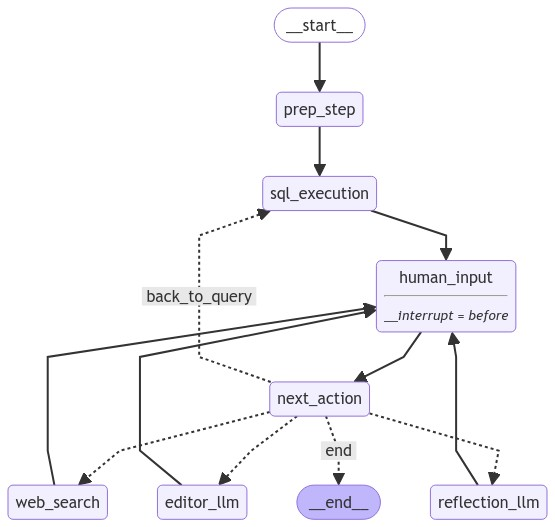

In [785]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# APPENDIX

In [ ]:
chat_history=[("user", "give me the top 10 repos with the highest total number of star with their name and url"),
              ("ai", "An error occurred: 000904 (42000): SQL compilation error: error line 1 at position 20 invalid identifier 'R.REPO_URL'"),
              ("user", "Github_Repo table doesn't have a repo url column. Do not make this mistake and try again.")
              ]
context_prompt = """
You are a SQL expert. \
Your goal is to write a sequence of SQL codes to answer the user's question. \
Find the most efficient way (shortest query time) to query the database to get the final answer. \
You have the ability to store intermediate step results in a multi-step solution. \
Use a multi-step approach if you need to join more than 2 tables. Joining more than 2 tables in a single step can result in timeout. \
Also take each table's size into consideration when devising the steps (use the row count as an approxi). You want to avoid joining huge tables. \
If you have to join huge tables together, find a way to reduce the number of rows before the join. \
Here are the table details: {database_details} """



In [370]:
#react_chat_prompt = hub.pull("hwchase17/react-chat")

text_chunk_1="""Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

TOOLS:
------

Assistant has"""

text_chunk_2="""To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes"""

text_chunk_3="""Observation: the result of the action
```

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: Do I need to use a tool? No
Final Answer: [your response here]
```"""

text_chunk_4="""New input: {input}
{agent_scratchpad}
""" # cannot replace this chunk

prompt_edited=react_chat_prompt.template.replace(text_chunk_1,"You have a record of the conversation history with user and")
prompt_edited=prompt_edited.replace(text_chunk_2,"Use the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do base on the conversation history")
prompt_edited=prompt_edited.replace(text_chunk_3,"Observation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question")
prompt_edited=prompt_edited.replace("New input:","User request:")

prompt_edited=PromptTemplate.from_template(prompt_edited)
prompt_edited.pretty_print()



You have a record of the conversation history with user and access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do base on the conversation history
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Previous conversation history:
{chat_history}

User request: {input}
{agent_scratchpad}


In [77]:
# tool method 1: session.sql()

@tool
def db_query_tool(query:str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = session.sql(query)
    if not result:
        return "Error: Query failed. Please rewrite and try again"
    return result.show()

print(db_query_tool.invoke("SELECT COUNT(*) AS total_rows FROM GITHUB_ARCHIVE.CYBERSYN.CYBERSYN_DATA_CATALOG"))

----------------
|"TOTAL_ROWS"  |
----------------
|325           |
----------------

None


In [ ]:
# tool method 2: db.run()

snowflake_url = f"snowflake://{user}:{password}@{account}/{database}/{schema}?warehouse={warehouse}&role={role}"
db = SQLDatabase.from_uri(snowflake_url)

@tool
def db_query_tool_v2(query:str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite and try again"
    return result

print(db_query_tool_v2.invoke("SELECT COUNT(*) AS total_rows FROM GITHUB_ARCHIVE.CYBERSYN.CYBERSYN_DATA_CATALOG;"))